In [42]:
import os
import torch
# import progressbar
import pandas as pd
import nibabel as nb
import numpy as np
from torch.utils.data import Dataset
# from tqdm import tqdm
# from skimage.transform import resize


In [2]:
class DatasetModel1(Dataset):
    """
    mode: either train, val, or test
    snp_windowsize: patch size
    """
    def __init__(self, base_path, neg_csv_path, pos_csv_path, mode, snp_windowsize, ideal_shape=(364, 448), output_shape=(224, 224), window_size=1, mu=0, std=1):
        self.mu = mu
        self.std = std
        self.window_size = window_size
        self.snp_windowsize = snp_windowsize
        self.ideal_shape = ideal_shape
        self.base_path = base_path
        self.neg_csv_path = neg_csv_path
        self.pos_csv_path = pos_csv_path

        pos_df = pd.read_csv(pos_csv_path)
        pos_df = pos_df[pos_df['mode'] == mode]
        neg_df = pd.read_csv(neg_csv_path)
        neg_df = neg_df[neg_df['mode'] == mode]

        data_info = pos_df.append(neg_df, ignore_index=True)

        self.images = []
        self.labels = []
        self.image_paths = []
        self.frame_num = []
        self.snp_positions = []


 
        for idx, row in tqdm(data_info.iterrows()):
            img, lbl, img_path, img_fn, img_position = self.create_patch(row)
            if img.shape != (61, 61):
                print(img.shape, img_path, img_fn, img_position)
                continue
            marginal_zero = np.zeros(output_shape)
            start_row = int((output_shape[0] - 61) / 2)
            start_col = int((output_shape[1] - 61) / 2)
            marginal_zero[start_row:start_row+61, start_col:start_col+61] = img
            self.images.append(marginal_zero)
            self.labels.append(lbl)
            self.image_paths.append(img_path)
            self.frame_num.append(img_fn)
            self.snp_positions.append(img_position)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.from_numpy(np.array([self.images[idx]] * 3))
#         img = torch.unsqueeze(img, 0)
        return {'image': img, 'label': self.labels[idx], 'image_path': self.image_paths[idx], 'frame_num': self.frame_num[idx], 'snp_index': self.snp_positions[idx]}

#     def rescale_images(self, ideal_shape, image):
#         current_shape = image.shape
#         lower_0 = int((ideal_shape[0] - current_shape[0]) / 2.0)
#         lower_1 = int((current_shape[1] - ideal_shape[1]) / 2.0)
#         upper_0 = ideal_shape[0] - lower_0 - current_shape[0]
#         upper_1 = ideal_shape[1] + lower_1
#         lower_part = np.zeros((lower_0, ideal_shape[1], current_shape[2]))
#         upper_part = np.zeros((upper_0, ideal_shape[1], current_shape[2]))

#         if current_shape[1] != ideal_shape[1]:
#             imgg = image[:, lower_1:upper_1, :]
#         else:
#             imgg = image

#         imgg = np.concatenate((lower_part, imgg), axis=0)
#         imgg = np.concatenate((imgg, upper_part), axis=0)
#         return imgg

    def create_patch(self, row):
        image = nb.load(os.path.join(self.base_path, row['v03_SWI_path'])).get_data()
#         image = self.rescale_images(self.ideal_shape, image)
        selected_frame = image[:, :, row['frame_number']]
        selected_frame = selected_frame / np.max(selected_frame)
        positions = row['patch_position'].split('_')
        i = int(positions[0])
        j = int(positions[1])

        img = selected_frame[i:i + self.snp_windowsize, j:j + self.snp_windowsize]
        if row['CMB_included'] == 'pos':
            label = 1
        elif row['CMB_included'] == 'neg':
            label = 0
        else:
            label = None
        return img, label, row['v03_SWI_path'], row['frame_number'], row['patch_position']


NameError: name 'Dataset' is not defined

In [21]:
import os
import nibabel as nb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
csv_path = '/w/246/gzk/PPMI/codes/first_model_csv_info.csv'

In [14]:
csv_df = pd.read_csv(csv_path)
csv_df.head()

,siteKey,researchGroup,subjectIdentifier,visitIdentifier,studyIdentifier,seriesIdentifier,subjectSex,subjectAge,ageQualifier,weightKg,...,Matrix X,Matrix Y,Matrix Z,Pixel Spacing X,Pixel Spacing Y,Manufacturer,Mfg Model,Field Strength,mode,preprocessed_3_path
0,7,PD,3102,Baseline,32507,103294,M,63.62,Y,99.5,...,240,256,176,1.0,1.0,SIEMENS,TrioTim,3.0,train,/w/246/gzk/PPMI/MRI_PD/PPMI/3102/MPRAGE_GRAPPA...
1,7,PD,3102,Symptomatic Therapy,55866,179003,M,64.62,Y,98.0,...,240,256,176,1.0,1.0,SIEMENS,TrioTim,3.0,train,/w/246/gzk/PPMI/MRI_PD/PPMI/3102/MPRAGE_GRAPPA...
2,7,PD,3102,Month 24,59426,193426,M,65.83,Y,96.7,...,240,256,176,1.0,1.0,SIEMENS,TrioTim,3.0,train,/w/246/gzk/PPMI/MRI_PD/PPMI/3102/MPRAGE_GRAPPA...
3,7,PD,3105,Baseline,32518,103326,M,68.52,Y,101.5,...,240,256,176,1.0,1.0,SIEMENS,TrioTim,3.0,train,/w/246/gzk/PPMI/MRI_PD/PPMI/3105/MPRAGE_GRAPPA...
4,7,PD,3105,Month 12,45290,148999,M,69.59,Y,98.4,...,240,256,176,1.0,1.0,SIEMENS,TrioTim,3.0,train,/w/246/gzk/PPMI/MRI_PD/PPMI/3105/MPRAGE_GRAPPA...


In [47]:
csv_df['Mfg Model'].unique()

array(['TrioTim', 'Prisma_fit', 'Verio', 'Biograph_mMR'], dtype=object)

In [38]:
shape_list = [(176, 240, 256), (192, 240, 256), (144, 240, 256), (160, 240, 256)]
for index, row in csv_df.iterrows():
    shape = nb.load(row['preprocessed_3_path']).get_data().shape
    if shape not in shape_list:
        print(shape)
#        print(row['Acquisition Plane'], row['Mfg Model'], row['Pulse Sequence'])
        
    

/tmp/ipykernel_74169/3044374704.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  shape = nb.load(row['preprocessed_3_path']).get_data().shape


(256, 240, 176)
(256, 240, 176)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 248, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(175, 240, 256)
(175, 240, 256)
(174, 240, 256)
(175, 240, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


In [20]:
for index, row in csv_df.iterrows():
    shape = nb.load(row['preprocessed_3_path']).get_data().shape
    print(shape, row['Acquisition Plane'], row['preprocessed_3_path'])
        
    

/tmp/ipykernel_74169/3629795341.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  shape = nb.load(row['preprocessed_3_path']).get_data().shape


(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3102/MPRAGE_GRAPPA/2010-11-23_09_51_22.0/S103294/PPMI_3102_MR_MPRAGE_GRAPPA__br_raw_20110406103050144_119_S103294_I226365_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3102/MPRAGE_GRAPPA/2011-11-21_09_02_40.0/S179003/PPMI_3102_MR_MPRAGE_GRAPPA__br_raw_20130107132615431_147_S179003_I353460_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3102/MPRAGE_GRAPPA/2013-02-06_10_38_32.0/S193426/PPMI_3102_MR_MPRAGE_GRAPPA__br_raw_20130626124847585_55_S193426_I378212_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3105/MPRAGE_GRAPPA/2011-03-24_13_04_58.0/S103326/PPMI_3105_MR_MPRAGE_GRAPPA__br_raw_20110406113707912_21_S103326_I226403_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3105/MPRAGE_GRAPPA/2012-04-18_11_44_39.0/S148999/PPMI_3105_MR_MPRAGE_GRAPPA__br_raw_20120503102146310_78_S148999_I301558_ROBEX_FieldCorrection.ni

(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3175/SAG_MPRAGE_GRAPPA/2013-05-10_10_55_48.0/S191158/PPMI_3175_MR_SAG_MPRAGE_GRAPPA__br_raw_20130603102706435_19_S191158_I374880_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3175/SAG_MPRAGE_GRAPPA/2014-04-23_10_13_18.0/S221708/PPMI_3175_MR_SAG_MPRAGE_GRAPPA__br_raw_20140609133552653_14_S221708_I430161_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3175/SAG_MPRAGE_GRAPPA/2016-08-24_10_47_33.0/S501576/PPMI_3175_MR_SAG_MPRAGE_GRAPPA__br_raw_20160926113649471_141_S501576_I778956_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3176/MPRAGE_GRAPPA/2012-05-07_08_32_06.0/S151282/PPMI_3176_MR_MPRAGE_GRAPPA__br_raw_20120522121131689_87_S151282_I305942_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3176/SAG_MPRAGE_GRAPPA/2013-05-29_09_04_49.0/S196299/PPMI_3176_MR_SAG_MPRAGE_GRAPPA__br_raw_20130724155527270_172_S196299_

(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3377/MPRAGE_GRAPPA/2016-06-29_07_55_43.0/S795972/PPMI_3377_MR_MPRAGE_GRAPPA__br_raw_20190211094615275_70_S795972_I1129394_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3378/MPRAGE_GRAPPA/2013-07-03_08_42_27.0/S199150/PPMI_3378_MR_MPRAGE_GRAPPA__br_raw_20130826122110631_129_S199150_I387325_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3378/MPRAGE_GRAPPA/2014-06-05_08_21_29.0/S228177/PPMI_3378_MR_MPRAGE_GRAPPA__br_raw_20140820153524793_22_S228177_I440193_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3378/MPRAGE_GRAPPA/2016-05-19_09_13_08.0/S484605/PPMI_3378_MR_MPRAGE_GRAPPA__br_raw_20160714171015809_140_S484605_I757805_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3380/MPRAGE_GRAPPA/2013-08-21_08_20_20.0/S203286/PPMI_3380_MR_MPRAGE_GRAPPA__br_raw_20131008143401678_48_S203286_I393637_ROBEX_FieldCorrection.n

(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3763/MPRAGE_GRAPPA/2013-11-13_08_14_47.0/S212783/PPMI_3763_MR_MPRAGE_GRAPPA__br_raw_20140218154157911_34_S212783_I414635_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3764/MPRAGE_GRAPPA/2011-11-16_09_20_44.0/S142698/PPMI_3764_MR_MPRAGE_GRAPPA__br_raw_20120305181534326_39_S142698_I288115_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3770/MPRAGE_GRAPPA/2012-02-08_10_16_11.0/S160386/PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20120809132337892_169_S160386_I322874_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3770/MPRAGE_GRAPPA/2013-02-27_08_04_21.0/S185770/PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20130402171720279_133_S185770_I365264_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3770/MPRAGE_GRAPPA/2014-02-19_07_53_30.0/S216367/PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154029492_80_S216367_I420360_ROBEX_FieldCorrection.ni

(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3838/MPRAGE_GRAPPA/2013-03-05_10_54_50.0/S187073/PPMI_3838_MR_MPRAGE_GRAPPA__br_raw_20130416124155609_60_S187073_I367371_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3838/MPRAGE_GRAPPA/2014-04-01_11_18_57.0/S217921/PPMI_3838_MR_MPRAGE_GRAPPA__br_raw_20140506160310219_48_S217921_I423752_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3838/MPRAGE_GRAPPA/2015-03-31_11_07_26.0/S277098/PPMI_3838_MR_MPRAGE_GRAPPA__br_raw_20150921101655165_5_S277098_I515247_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3838/MPRAGE_GRAPPA/2017-04-04_10_51_15.0/S606267/PPMI_3838_MR_MPRAGE_GRAPPA__br_raw_20170907120732542_124_S606267_I901176_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/3863/MPRAGE_GRAPPA/2012-03-30_08_50_31.0/S171139/PPMI_3863_MR_MPRAGE_GRAPPA__br_raw_20121017113226460_47_S171139_I340682_ROBEX_FieldCorrection.nii


(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/41184/MPRAGE_GRAPPA/2019-05-10_09_56_48.0/S871271/PPMI_41184_MR_MPRAGE_GRAPPA__br_raw_20190909114620378_86_S871271_I1224295_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/41184/MPRAGE_w__GRAPPA/2015-03-16_10_42_36.0/S308778/PPMI_41184_MR_MPRAGE_w__GRAPPA_br_raw_20151116125509863_44_S308778_I554285_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/4135/MPRAGE_GRAPPA/2013-03-01_14_34_50.0/S193229/PPMI_4135_MR_MPRAGE_GRAPPA__br_raw_20130625114205861_64_S193229_I377956_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/4136/MPRAGE_GRAPPA/2013-02-28_08_50_55.0/S193241/PPMI_4136_MR_MPRAGE_GRAPPA__br_raw_20130625121634276_122_S193241_I377972_ROBEX_FieldCorrection.nii
(176, 240, 256) SAGITTAL /w/246/gzk/PPMI/MRI_PD/PPMI/4136/MPRAGE_w__GRAPPA/2014-05-06_13_49_47.0/S225641/PPMI_4136_MR_MPRAGE_w__GRAPPA_br_raw_20140820193130785_142_S225641_I436429_ROBEX_Fie

/tmp/ipykernel_74169/14080972.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_1 = test_1.get_data()


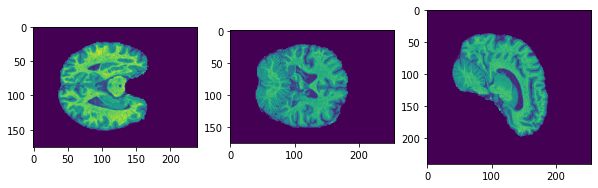

In [28]:
test_1 = nb.load('/w/246/gzk/PPMI/MRI_PD/PPMI/3102/MPRAGE_GRAPPA/2010-11-23_09_51_22.0/S103294/PPMI_3102_MR_MPRAGE_GRAPPA__br_raw_20110406103050144_119_S103294_I226365_ROBEX_FieldCorrection.nii')
test_1 = test_1.get_data()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_1[:, :, 100])
plt.subplot(1, 3, 2)
plt.imshow(test_1[:, 100, :])
plt.subplot(1, 3, 3)
plt.imshow(test_1[100, :, :])
# (176, 240, 256)

/tmp/ipykernel_74169/2834260532.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_2 = test_2.get_data()


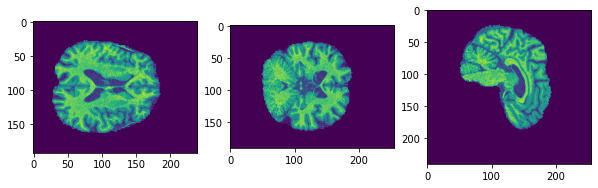

In [36]:
test_2 = nb.load('/w/246/gzk/PPMI/MRI_PD/PPMI/3107/Sag_MPRAGE_GRAPPA/2016-04-06_13_56_12.0/S426368/PPMI_3107_MR_Sag_MPRAGE_GRAPPA__br_raw_20160422141545033_185_S426368_I689550_ROBEX_FieldCorrection.nii')
test_2 = test_2.get_data()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_2[:, :, 140])
plt.subplot(1, 3, 2)
plt.imshow(test_2[:, 90, :])
plt.subplot(1, 3, 3)
plt.imshow(test_2[100, :, :])
#(192, 240, 256)

/tmp/ipykernel_74169/2178610093.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_3 = test_3.get_data()


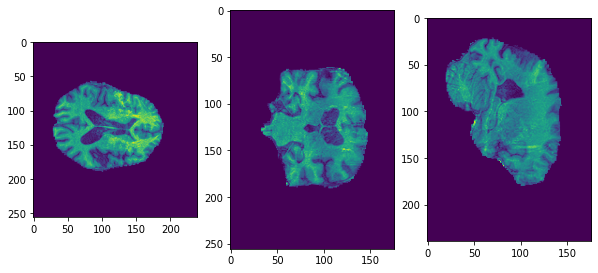

In [27]:
test_3 = nb.load('/w/246/gzk/PPMI/MRI_PD/PPMI/3116/MPRAGE_GRAPPA/2013-11-13_12_55_49.0/S214312/PPMI_3116_MR_MPRAGE_GRAPPA__br_raw_20140319120536400_79_S214312_I417050_ROBEX_FieldCorrection.nii')
test_3 = test_3.get_data()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_3[:, :, 100])
plt.subplot(1, 3, 2)
plt.imshow(test_3[:, 100, :])
plt.subplot(1, 3, 3)
plt.imshow(test_3[100, :, :])
#(256, 240, 176)

/tmp/ipykernel_74169/658561547.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  test_4 = test_4.get_data()


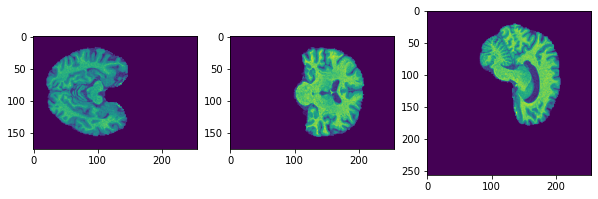

In [40]:
test_4 = nb.load('/w/246/gzk/PPMI/MRI_PD/PPMI/3574/MPRAGE_GRAPPA/2015-10-01_10_16_34.0/S331812/PPMI_3574_MR_MPRAGE_GRAPPA__br_raw_20151215152334247_68_S331812_I581096_ROBEX_FieldCorrection.nii')
test_4 = test_4.get_data()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_4[:, :, 130])
plt.subplot(1, 3, 2)
plt.imshow(test_4[:, 100, :])
plt.subplot(1, 3, 3)
plt.imshow(test_4[100, :, :])
#(256, 240, 176)

In [48]:
class ProcessedDataset(Dataset):
    """
    mode: either train, val, or test
    snp_windowsize: patch size
    """
    def __init__(self, csv_file, mode):
        
        data_info = pd.read_csv(csv_file)
        data_info = data_info[data_info['mode'] == mode]

        self.images = []
        self.labels = []
        self.image_paths = []
        self.frame_num = []
        
        model_mapping_dict = {'TrioTim':0, 'Prisma_fit':1, 'Verio':2, 'Biograph_mMR':3}
        
        for idx, row in tqdm(data_info.iterrows()):
            img = nb.load(row['preprocessed_3_path']).get_data()
            if img.shape[0] == 256: ### to avoid biasing the model with different view of the image acuisition
                continue
                
            img = self.intensity_normalization(img)    
            img = self.image_padding(img)
            
            for i in range(img.shape[2]):
                self.images.append(img[:, :, i])
                self.labels.append(model_mapping_dict[row['Mfg Model']])
                self.image_paths.append(row['preprocessed_3_path'])
                self.frame_num.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.from_numpy(np.array(self.images[idx]))
        img = torch.unsqueeze(img, 0)
        return {'image': img, 'label': self.labels[idx], 'image_path': self.image_paths[idx], 'frame_num': self.frame_num[idx]}
    
    def intensity_normalization(self, raw):
        return (raw - np.mean(raw)) / np.std(raw)
    
    def image_padding(self, raw):
        marginal = np.zeros((256, 256, 256))
        idx_0 = int((256 - shape[0]) / 2.0)
        idx_1 = int((256 - shape[1]) / 2.0)
        idx_2 = int((256 - shape[2]) / 2.0)

        marginal[idx_0 : idx_0 + shape[0], idx_1: idx_1 + shape[1], idx_2: idx_2 + shape[2] ] = raw
        return marginal